In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt

import copy

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


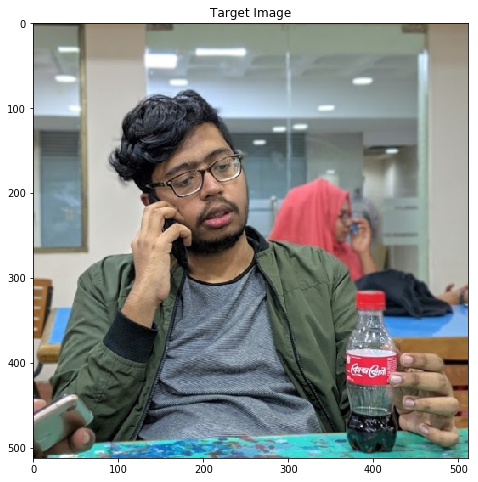

In [21]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
unloader = transforms.ToPILImage()  # reconvert into PIL image
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

### Select image here ###
image = image_loader("./images/abr.jpg")
fig = plt.figure(figsize=(16,8))
plt.imshow(unloader(image.cpu().clone().squeeze(0))) # content
plt.title('Target Image')

plt.show()

In [22]:
## download and assign VGG19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()
print(vgg)
vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [24]:
# desired depth layers to compute style/content losses :
target_layers = ['conv_4']
# layers_example = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

cnn = copy.deepcopy(vgg)

# normalization module
normalization = Normalization(vgg_normalization_mean, vgg_normalization_std).to(device)

# assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
# to put in modules that are supposed to be activated sequentially
model = nn.Sequential(normalization)

i = 0  # increment every time we see a conv
j = 0
for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    model.add_module(name, layer)

    if name in target_layers:
        ####### get content from the model's conv layers: #######
        feature_vec = model(image).detach()
    j += 1

# now we trim off the layers after the last content and style losses
for i in range(len(model) - 1, -1, -1):
    if i == j :
        break

model = model[:(i + 1)]

print(feature_vec, feature_vec.shape)
print(' --- ')
print(model)
# return model, feature_vec

tensor([[[[ 0.2517, -0.5296, -0.3648,  ...,  1.2094,  2.5249,  5.3571],
          [ 0.8074,  2.2916,  1.3817,  ..., -0.9422,  0.9017,  2.7500],
          [-0.8844,  0.1471,  0.4953,  ..., -1.3492, -0.0750,  1.7480],
          ...,
          [-0.9584, -0.7727,  1.3586,  ...,  1.3934, -4.3348, -4.4620],
          [-0.4089,  2.0497,  0.6539,  ..., -2.8055, -6.6052, -6.3655],
          [ 0.3060,  1.4758,  2.2579,  ..., -2.3493, -4.9114, -0.3147]],

         [[ 3.3738,  1.3460, -0.4100,  ..., -0.6359, -0.8051,  0.6215],
          [-4.4233, -0.9828, -2.6184,  ..., -1.9478, -2.0197, -0.1560],
          [-4.6686, -1.2939, -4.2228,  ..., -1.0568, -1.3970,  0.4364],
          ...,
          [ 0.7379, -1.3476, -1.4239,  ..., -2.2527, -5.0426, -1.1487],
          [ 7.6134, -1.5261, -4.7938,  ..., -4.2048, -2.4460, -0.6059],
          [ 2.7970,  4.0509, -2.1865,  ..., -0.7991, -2.7851,  0.5852]],

         [[ 3.2390,  0.2984, -0.4478,  ..., -0.6960,  0.1822, -2.5116],
          [-2.7486, -4.2066, -